In [102]:
import scipy.io
mat = scipy.io.loadmat('../MAT/medialALM_mask_150um3Dgauss_Bilateral.mat')
ALM_mat = scipy.io.loadmat('../MAT/MouseLightData_ALM_100um.mat')

In [2]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('seaborn-poster')
vox = mat['F_smooth']

In [276]:
import glob
from pynwb import NWBHDF5IO, NWBFile, TimeSeries
import ast

nwb_files = glob.glob("..\M440959\*.nwb")
nwb_io = []

for name in nwb_files:
    io = NWBHDF5IO(name, mode="r").read()
    nwb_io.append(io)
    
pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop = [],[],[],[],[],[],[],[]
for name in nwb_files:  
    with NWBHDF5IO(name, "r") as io:
        read_nwbfile = io.read()
        #print(read_nwbfile.acquisition["BehavioralEvents"]["trialend_start_times"].timestamps[:4])
        #print(read_nwbfile.acquisition["BehavioralEvents"]["trialend_stop_times"].timestamps[:4])
        pre_start.append(read_nwbfile.acquisition["BehavioralEvents"]["presample_start_times"].timestamps[:])
        pre_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["presample_stop_times"].timestamps[:])
        sample_start.append(read_nwbfile.acquisition["BehavioralEvents"]["sample_start_times"].timestamps[:])
        sample_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["sample_stop_times"].timestamps[:])
        delay_start.append(read_nwbfile.acquisition["BehavioralEvents"]["delay_start_times"].timestamps[:])
        delay_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["delay_stop_times"].timestamps[:])
        go_start.append(read_nwbfile.acquisition["BehavioralEvents"]["go_start_times"].timestamps[:])
        go_stop.append(read_nwbfile.acquisition["BehavioralEvents"]["go_stop_times"].timestamps[:])
      
      
def Clean_data(pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop):
    for i in range(len(pre_start)):
        sample_start[i] = np.intersect1d(pre_stop[i], sample_start[i])
        sample_stop[i] = np.intersect1d(sample_stop[i], delay_start[i])
        delay_start[i] = np.intersect1d(delay_start[i], sample_stop[i])
        delay_stop[i] = np.intersect1d(delay_stop[i], go_start[i])
    return pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop

pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop = Clean_data(pre_start,pre_stop,sample_start,sample_stop,delay_start,delay_stop,go_start,go_stop)
    
trials_df = []
for i in range(len(nwb_files)):
    trials_df.append(nwb_io[i].trials.to_dataframe().drop(['trial','task','trial_uid', 'photostim_power','photostim_duration','auto_water', 'free_water'],axis=1))
    trials_df[i] = trials_df[i].assign(pre_start = pre_start[i],
                         pre_stop = pre_stop[i],
                         sample_start = pre_stop[i],
                         sample_stop = sample_stop[i],
                         delay_start = delay_start[i],
                         delay_stop = delay_stop[i],
                         go_start = go_start[i],
                         go_stop = go_stop[i])
    trials_df[i]['ses_no'] = i+1
units_df = []
for i in range(len(nwb_files)):
    units_df.append(nwb_io[i].units.to_dataframe().query("classification == 'good'").reset_index())
    units_df[i]['ses_no'] = i+1
    units_df[i]['Region'] = units_df[i].electrodes.apply(lambda x: ast.literal_eval(x.location.values[0])['brain_regions'])

unit_result = pd.DataFrame()
trial_result = pd.DataFrame()

for i in range(len(nwb_files)):
    trial_result = pd.concat([trial_result, trials_df[i]])
    unit_result = pd.concat([unit_result, units_df[i]])

unit_result.Region.unique()

array(['left ALM', 'left Thalamus', 'left Midbrain'], dtype=object)

In [278]:
trials_Data = trial_result.query("photostim_onset == 'N/A' and outcome == 'hit' ")
trials_Data = trials_Data.query(" (delay_stop - delay_start) > 1 and (delay_stop - delay_start) < 1.3")
trials_Data = trials_Data.query(" (stop_time - start_time) < 5.3")
trials_Data_L = trials_Data[ trials_Data['trial_instruction'] == 'left'].reset_index().query(" ses_no == 1 ")
trials_Data_L

id  start_time  stop_time photostim_onset  task_protocol  \
0      9     58.4139    63.2594             N/A              1   
1     10     65.1150    70.2301             N/A              1   
2     12     79.1054    84.0787             N/A              1   
3     21    134.5271   139.4989             N/A              1   
4     22    141.3252   146.2507             N/A              1   
..   ...         ...        ...             ...            ...   
96   402   2670.8524  2675.7538             N/A              1   
97   406   2698.8187  2703.6468             N/A              1   
98   407   2705.8569  2710.6820             N/A              1   
99   408   2712.8911  2717.6641             N/A              1   
100  410   2725.5786  2730.5768             N/A              1   

    trial_instruction early_lick outcome  pre_start   pre_stop  sample_start  \
0                left   no early     hit    58.9139    58.9239       58.9239   
1                left   no early     hit    65.6150    65.6250       65.6250   
2                left   no early     hit    79.6054    79.6154       79.6154   
3                left   no early     hit   135.0271   135.0371      135.0371   
4                left   no early     hit   141.8252   141.8352      141.8352   
..                ...        ...     ...        ...        ...           ...   
96               left   no early     hit  2671.3524  2671.3624     2671.3624   
97               left   no early     hit  2699.3187  2699.3287     2699.3287   
98               left   no early     hit  2706.3569  2706.3669     2706.3669   
99               left   no early     hit  2713.3911  2713.4011     2713.4011   
100              left   no early     hit  2726.0786  2726.0886     2726.0886   

     sample_stop  delay_start  delay_stop   go_start    go_stop  ses_no  
0        60.3130      60.3130     61.5130    61.5130    61.5630       1  
1        67.1732      67.1732     68.3732    68.3732    68.4232       1  
2        81.1465      81.1465     82.3465    82.3465    82.3965       1  
3       136.5096     136.5096    137.7096   137.7096   137.7596       1  
4       143.3449     143.3449    144.5449   144.5449   144.5949       1  
..           ...          ...         ...        ...        ...     ...  
96     2672.8169    2672.8169   2674.0169  2674.0169  2674.0669       1  
97     2700.7052    2700.7052   2701.9052  2701.9052  2701.9552       1  
98     2707.7089    2707.7089   2708.9089  2708.9089  2708.9589       1  
99     2714.8004    2714.8004   2716.0004  2716.0004  2716.0504       1  
100    2727.5441    2727.5441   2728.7441  2728.7441  2728.7941       1  

[101 rows x 17 columns]

In [96]:
unit_result.Region.value_counts()

left Thalamus    236
left ALM          69
left Midbrain     39
Name: Region, dtype: int64

In [237]:
units_Data = unit_result.query(" Region == 'left Thalamus'")

def get_ccf(unit_number):
    x = float(units_Data.electrodes[unit_number].reset_index().x.values)
    y = float(units_Data.electrodes[unit_number].reset_index().y.values)
    z = float(units_Data.electrodes[unit_number].reset_index().z.values)
    return x, y, z

In [240]:
ids=[]
for i in range(len(units_Data)):
    try:
        if(float(units_Data.electrodes[i].reset_index().y.values) > 0):
            ids.append(i)
    except Exception as err:
        pass

In [254]:
units_Data.loc[125]

id                                                                         430
unit                                                                       219
sampling_rate                                                            30000
unit_quality                                                              good
unit_posx                                                                 11.0
unit_posy                                                               1260.0
unit_amp                                                            112.798597
unit_snr                                                               3.07629
isi_violation                                                         0.059234
avg_firing_rate                                                        10.8454
drift_metric                                                          0.433702
left_trials_drift_metric                                              0.447236
right_trials_drift_metric                           

In [170]:
x_ccf, y_ccf, z_ccf = get_ccf(unit_number=125)
x_ccf,y_ccf,z_ccf

(6460.0, 3500.0, 6560.0)

In [98]:
x_ccf, y_ccf, z_ccf = get_ccf(unit_number=125)

x,y,z=[],[],[]
for i in list(units_Data.electrodes.reset_index()['index'][:]):
    try:
        x_ccf, y_ccf, z_ccf = get_ccf(i)
        x.append(x_ccf)
        y.append(y_ccf)
        z.append(z_ccf)

    except Exception as err:
        pass

In [149]:
vox.shape

(400, 570, 660)

In [150]:
len(x)

64

In [151]:
np.array(y)/20   #use 232

array([175., 175., 175., 174., 175., 173., 173., 172., 173., 172., 171.,
       172., 171., 169., 169., 168., 167., 166., 165., 165., 162., 161.,
       159., 159., 156., 130., 129.,  59.,  56.,  55.,  54.,  54.,  50.,
        50., 234., 233., 232., 232., 227., 218., 214., 214., 214., 211.,
       207., 204., 204., 200., 198., 198., 187., 185., 167., 132., 198.,
       280., 280., 279., 277., 269., 262., 260., 260., 259.])

3500.0


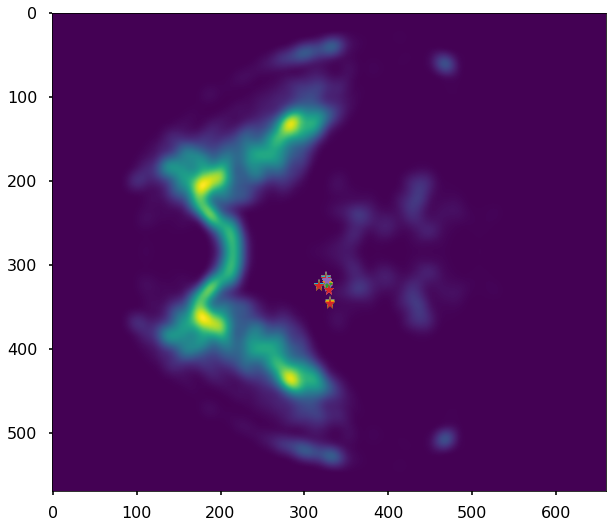

3500.0


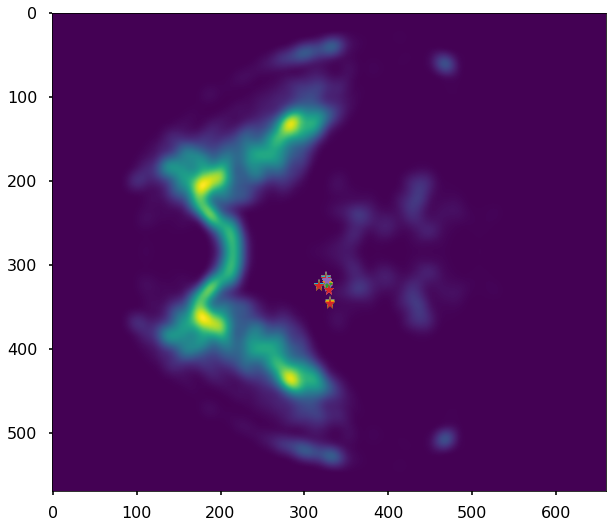

3500.0


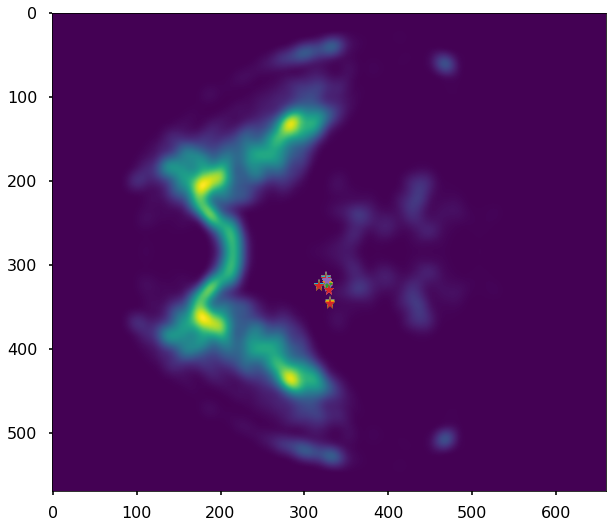

3480.0


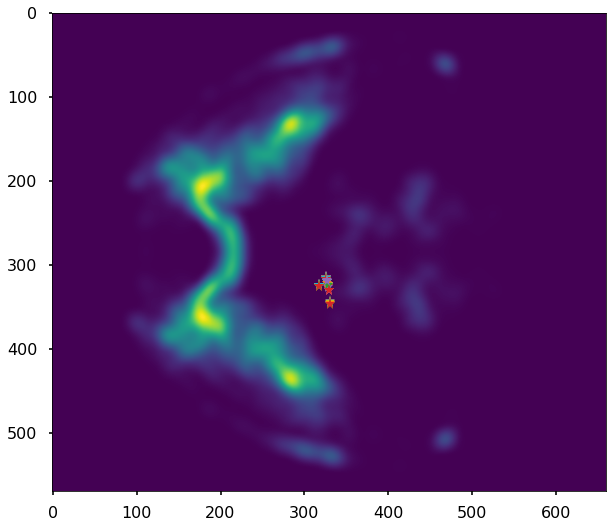

3500.0


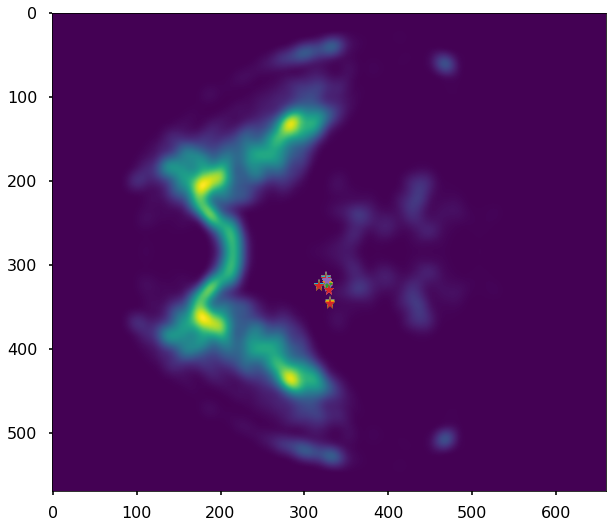

3460.0


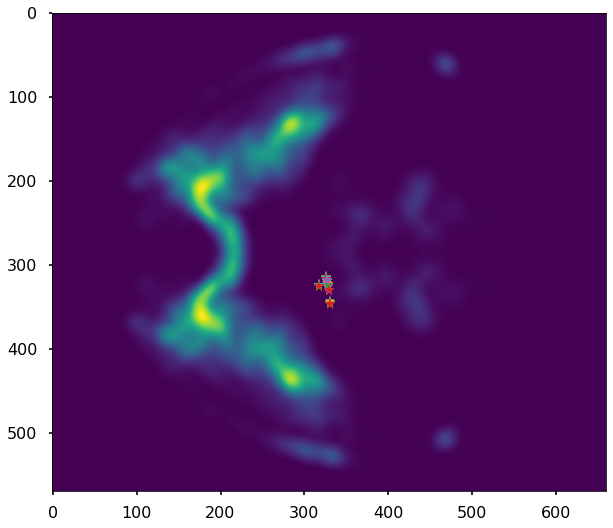

3460.0


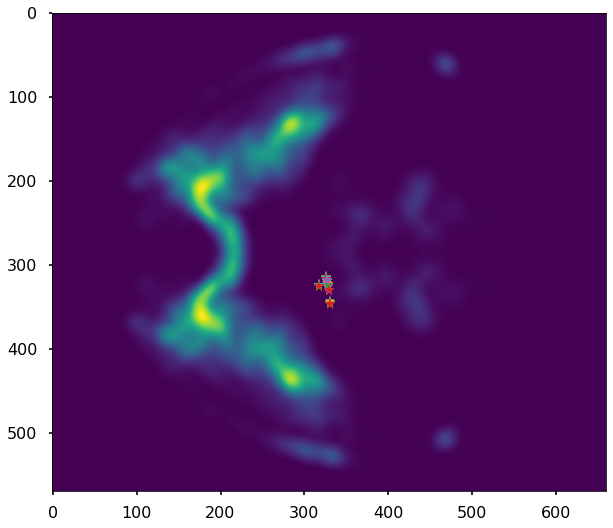

3440.0


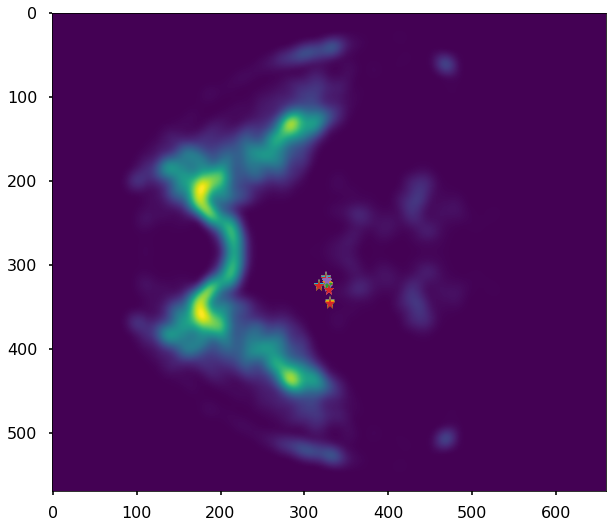

3460.0


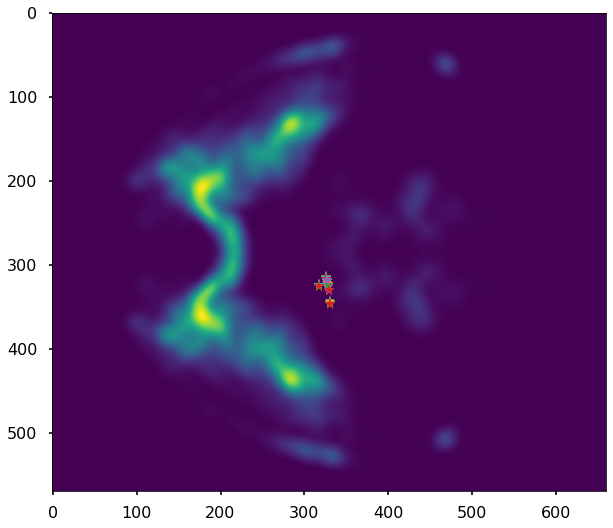

3440.0


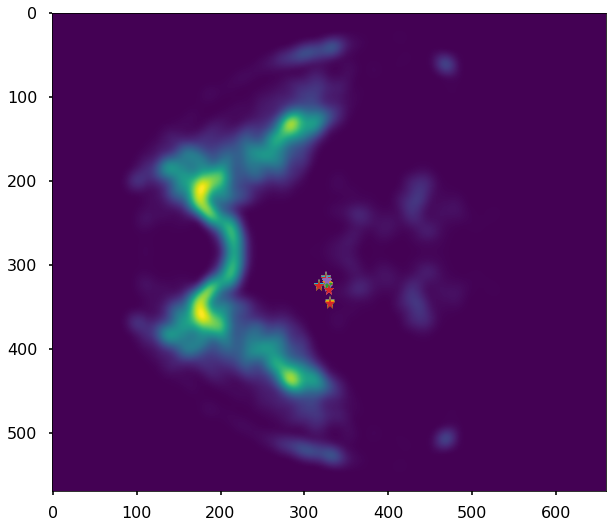

3420.0


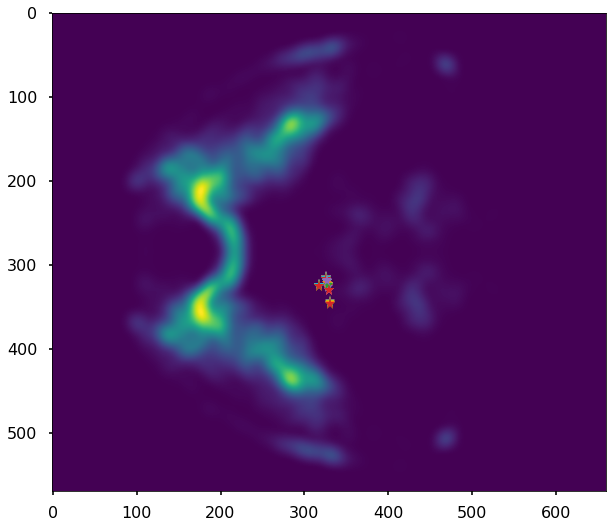

3440.0


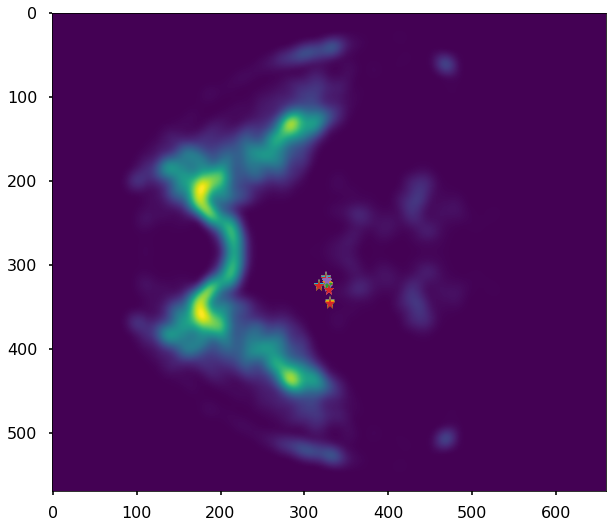

3420.0


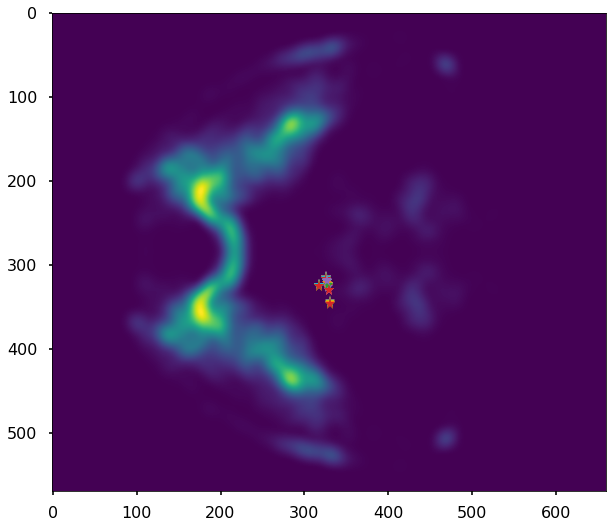

3380.0


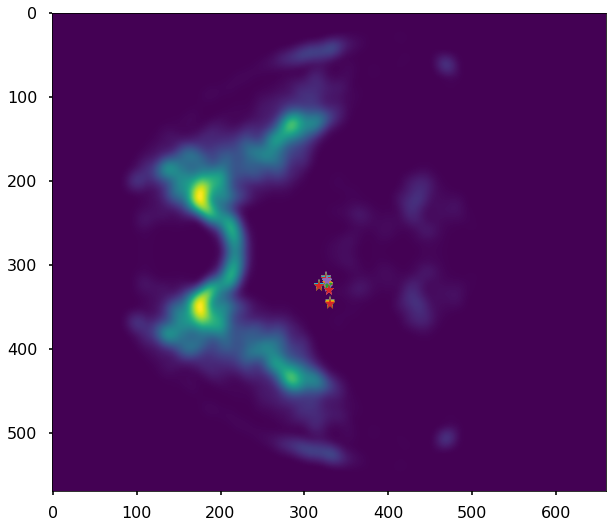

3380.0


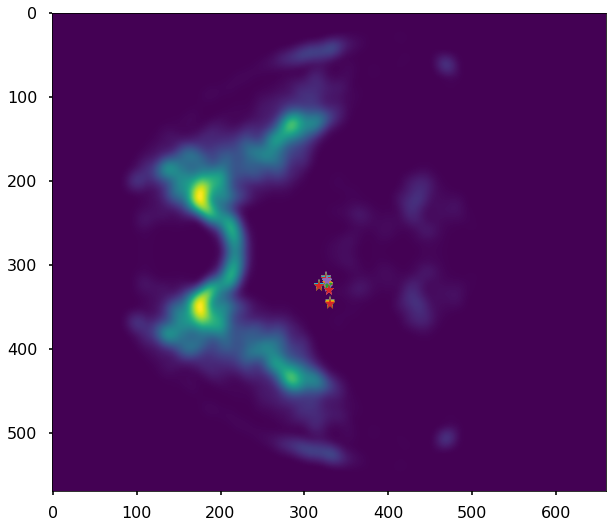

3360.0


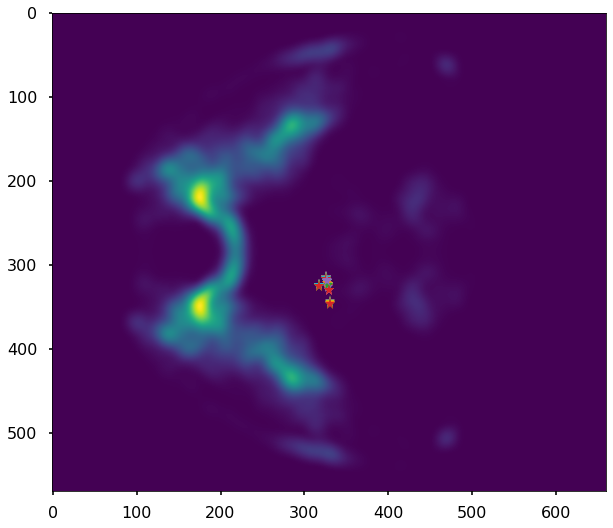

3340.0


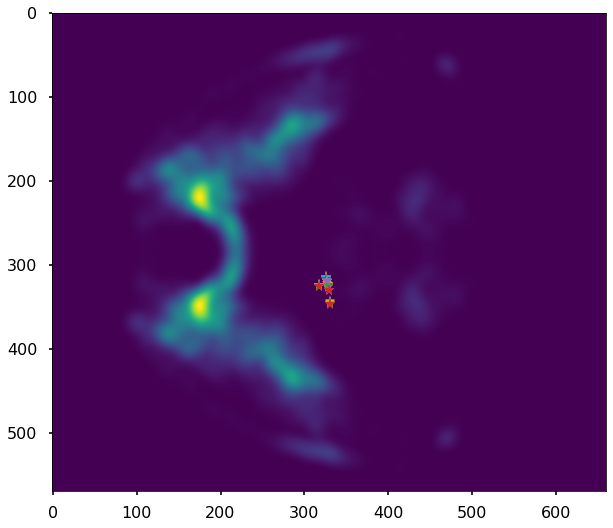

3320.0


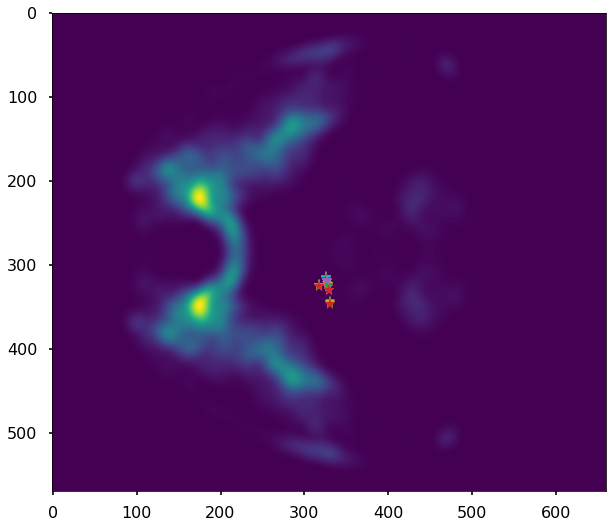

3300.0


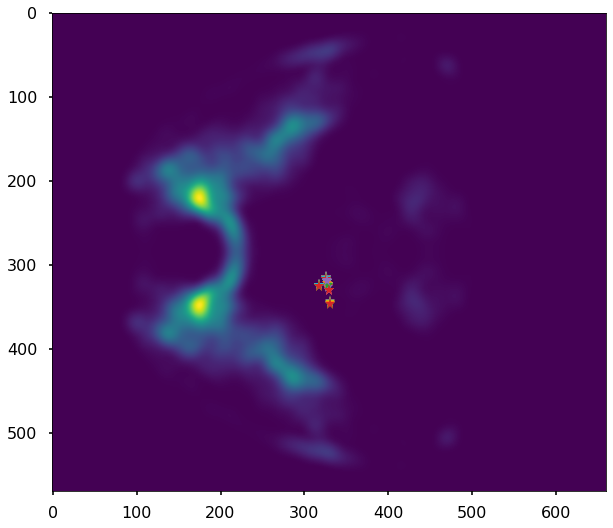

3300.0


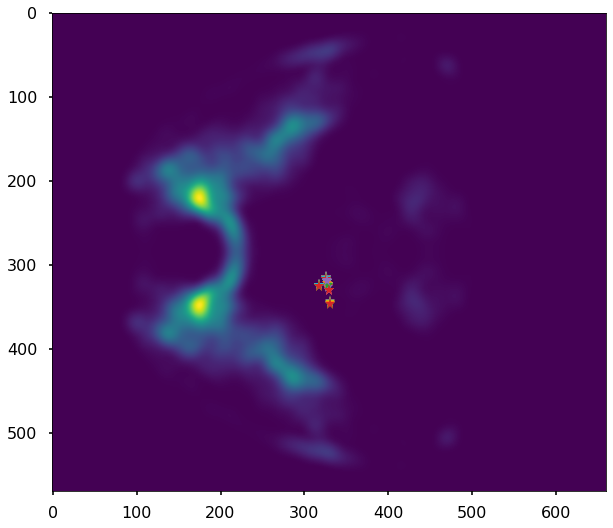

3240.0


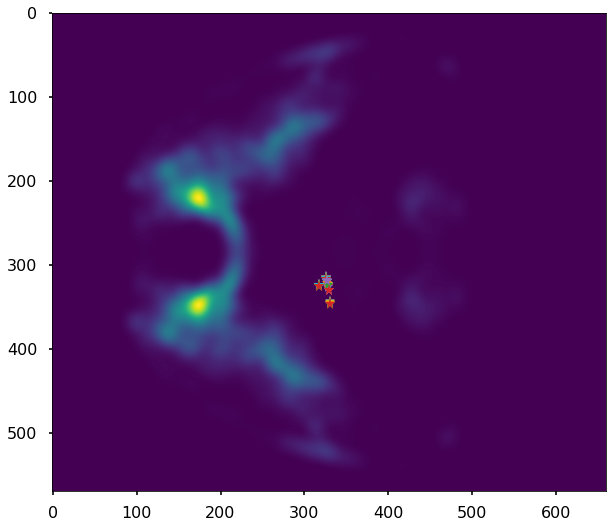

3220.0


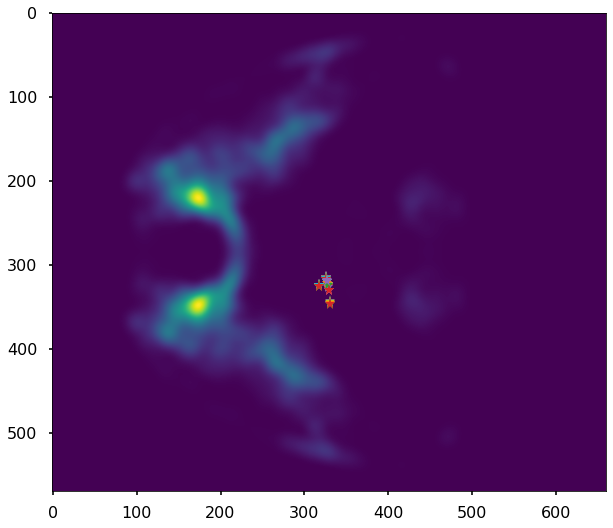

3180.0


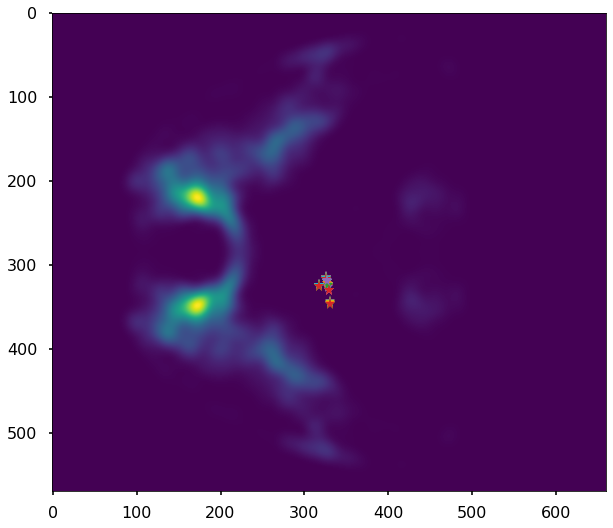

3180.0


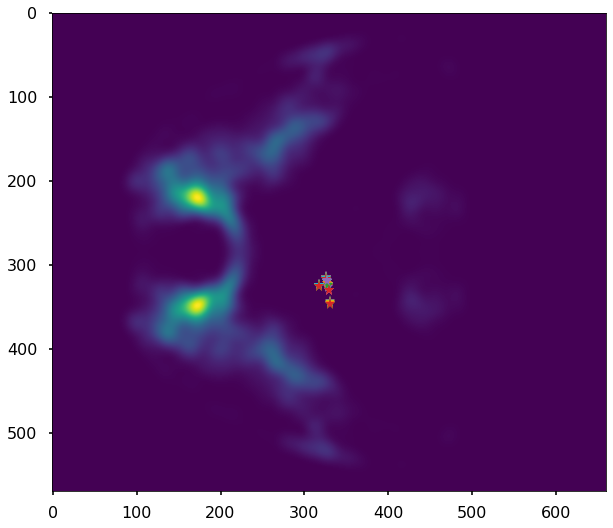

3120.0


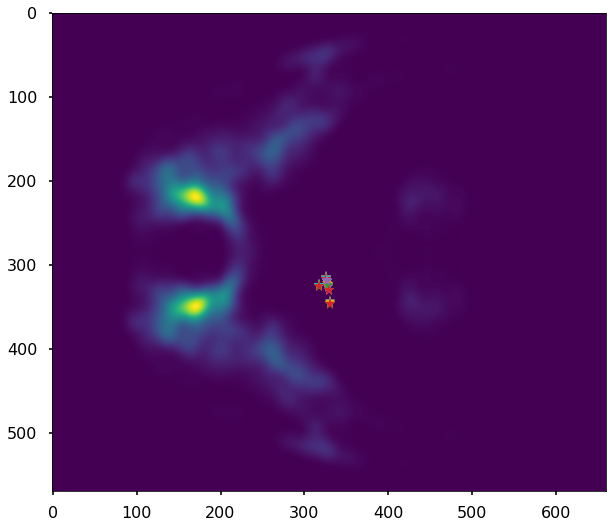

2600.0


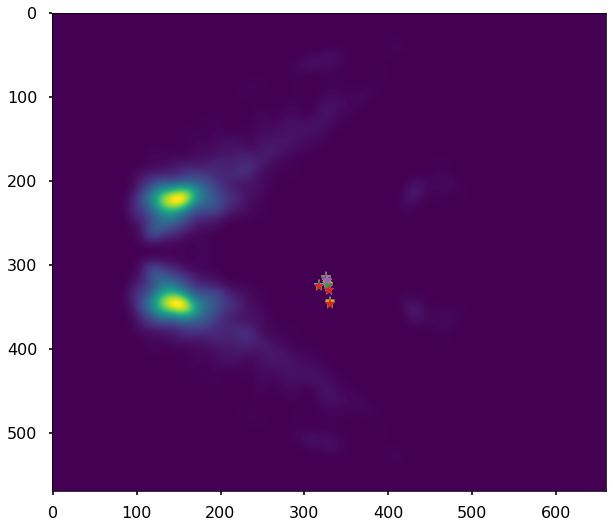

2580.0


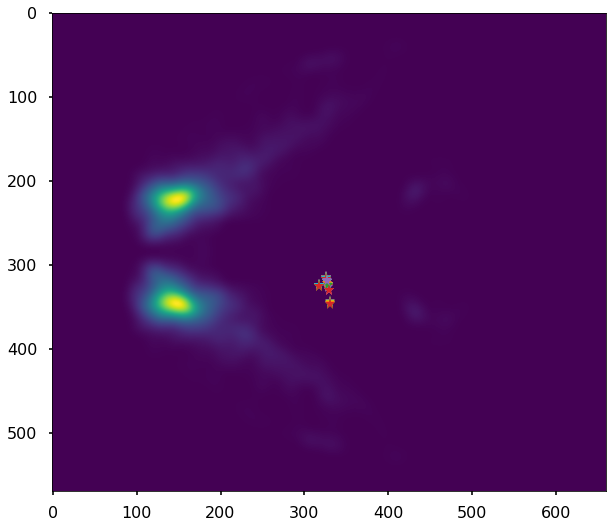

1180.0


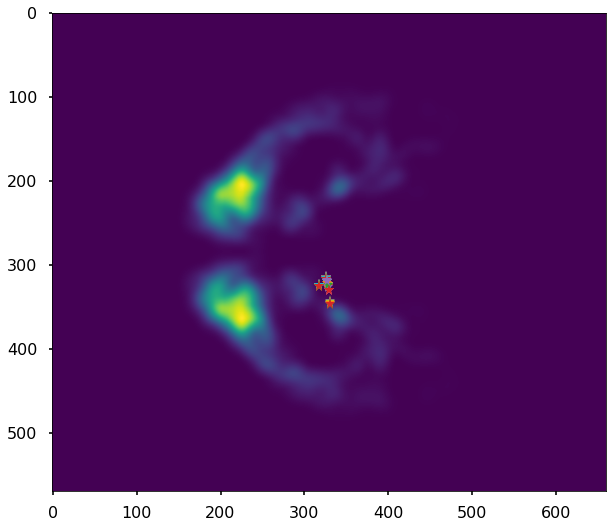

1120.0


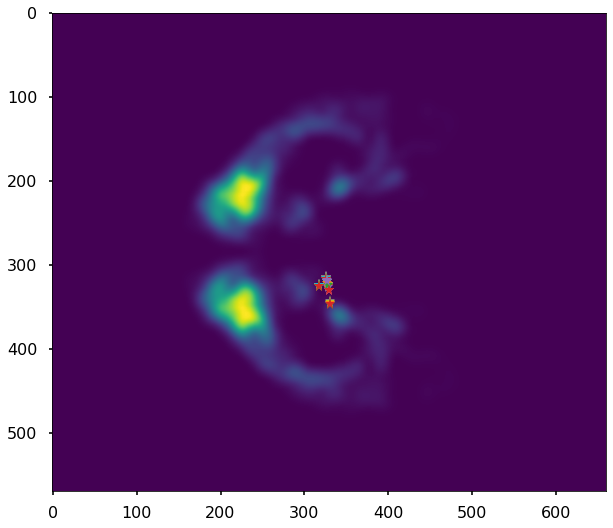

1100.0


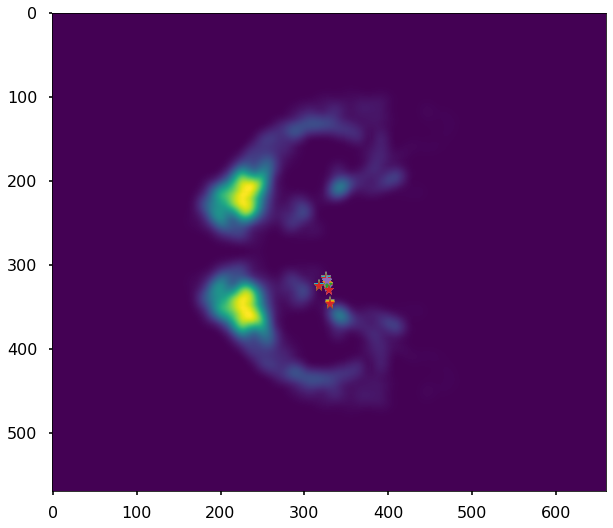

1080.0


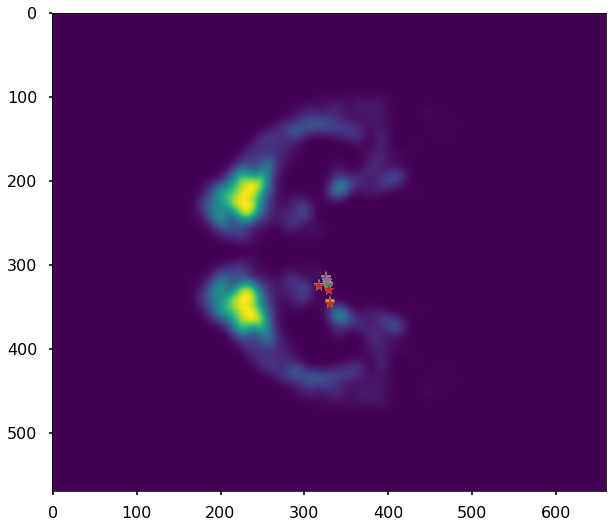

1080.0


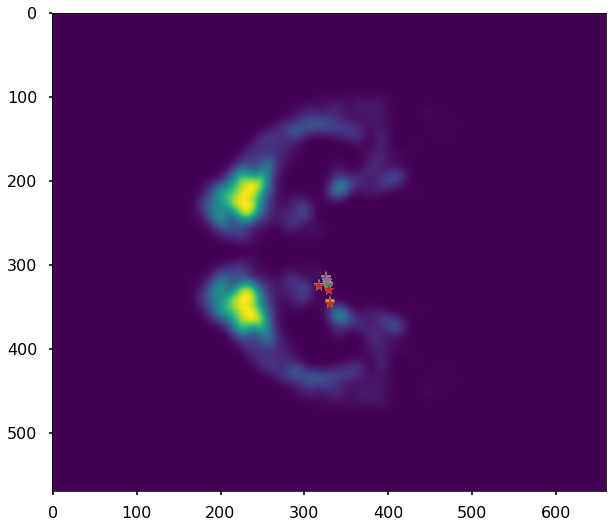

1000.0


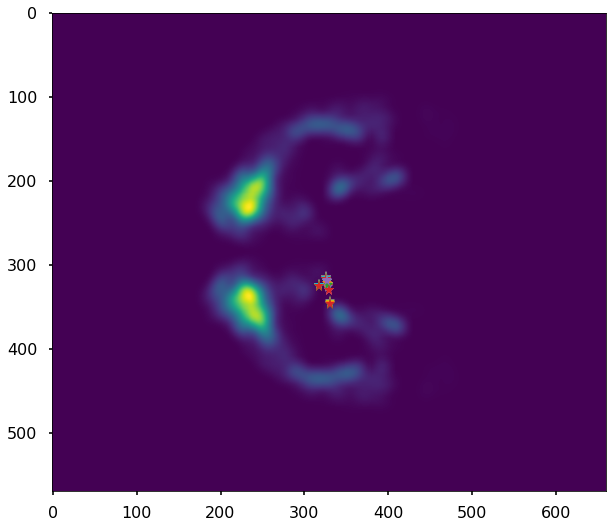

1000.0


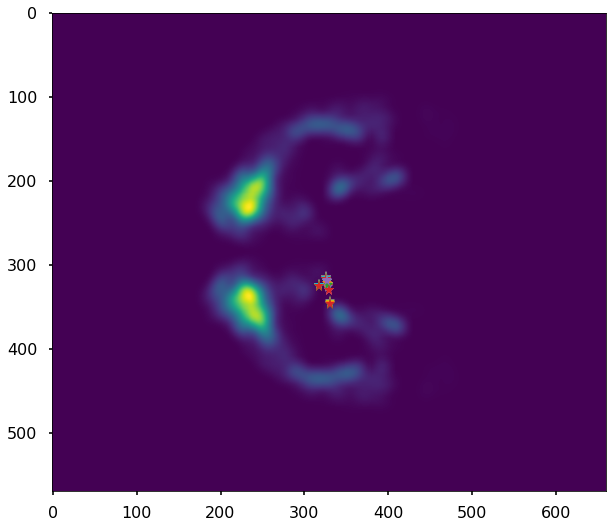

4680.0


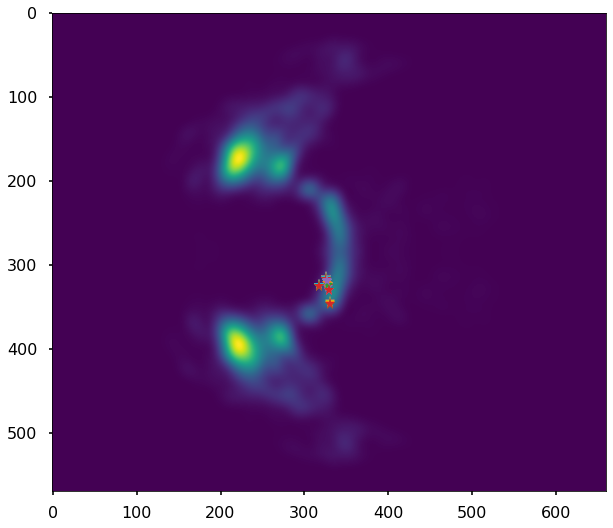

4660.0


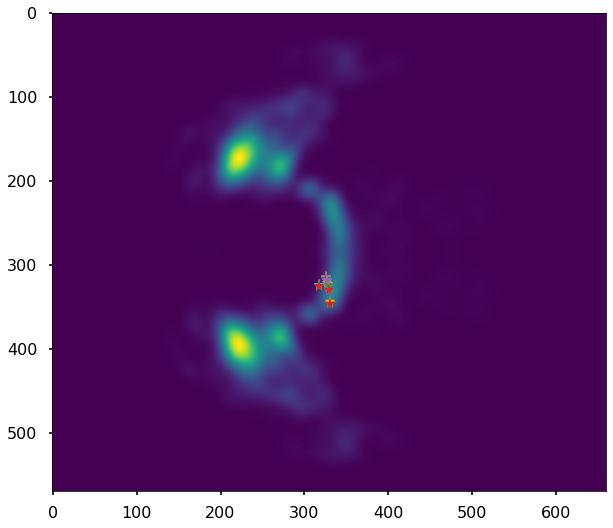

4640.0


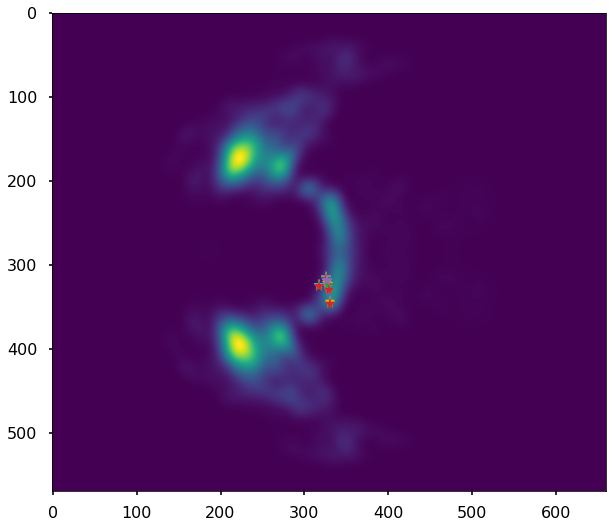

4640.0


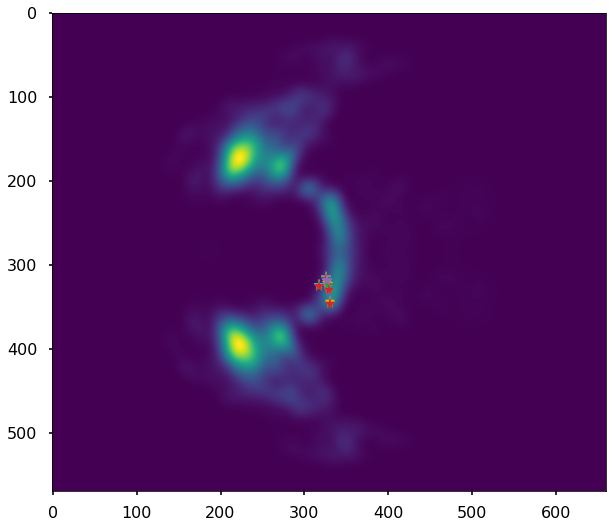

4540.0


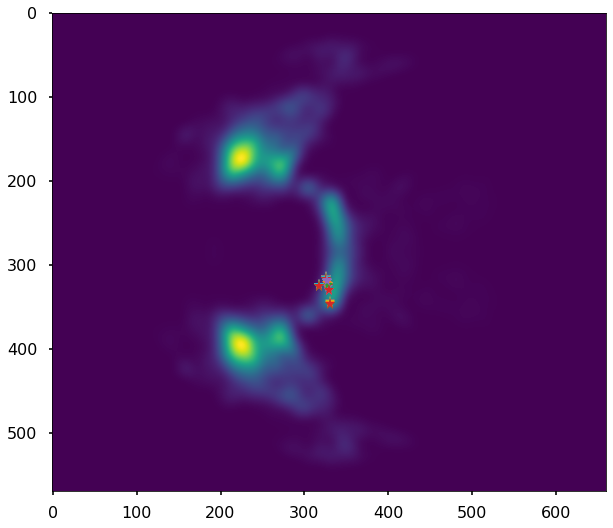

4360.0


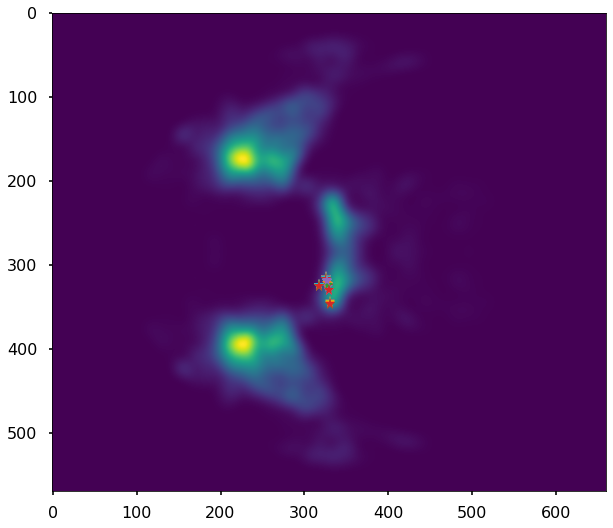

4280.0


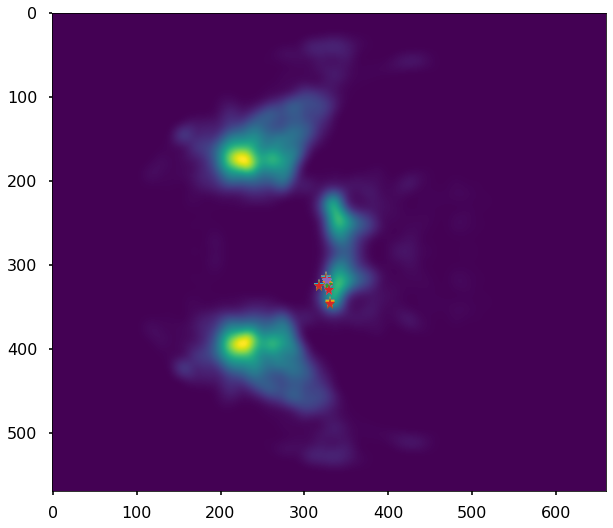

4280.0


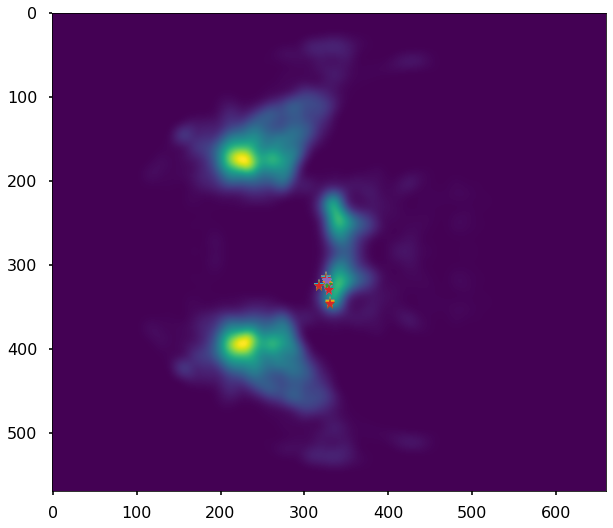

4280.0


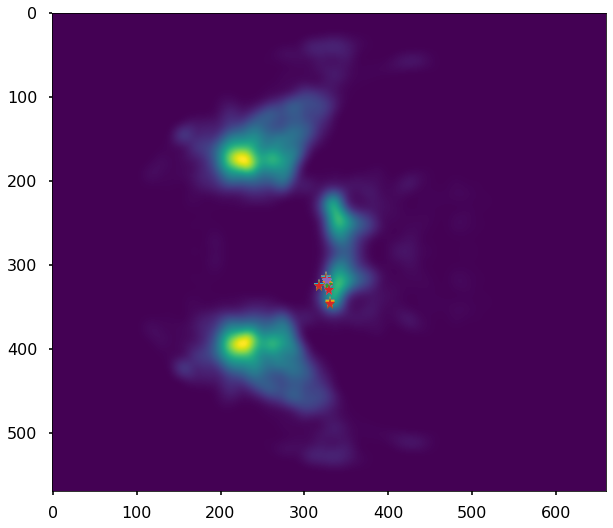

4220.0


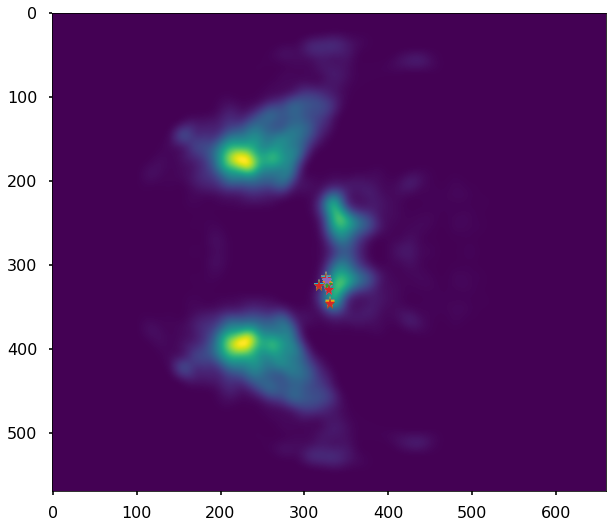

4140.0


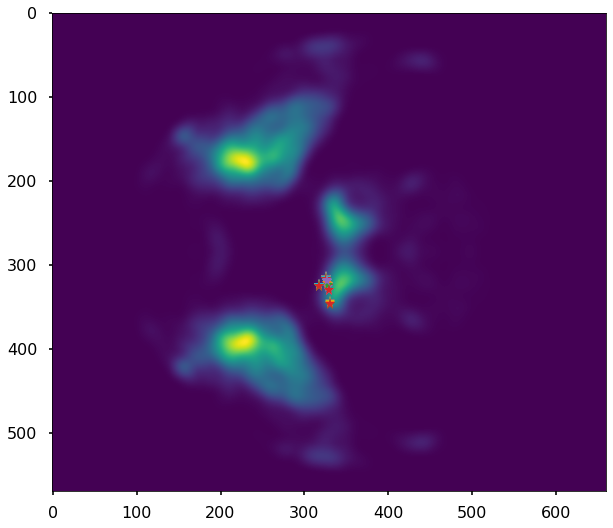

4080.0


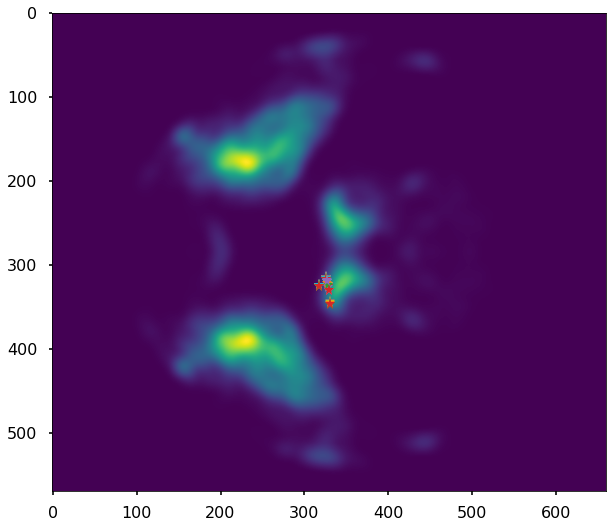

4080.0


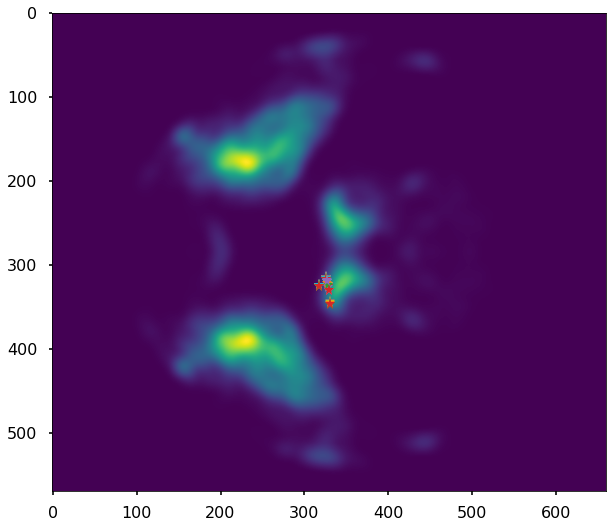

4000.0


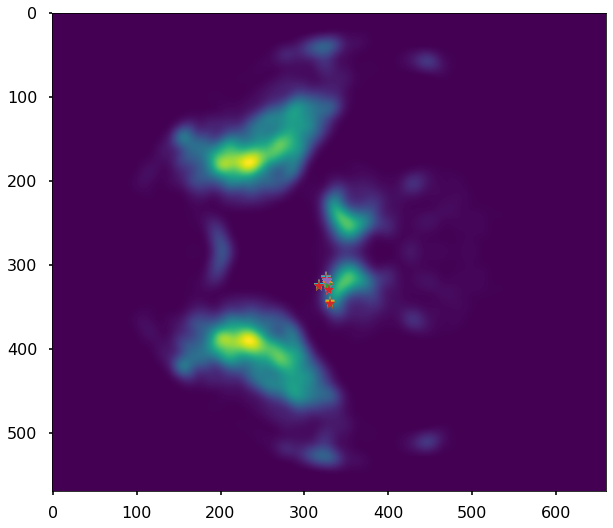

3960.0


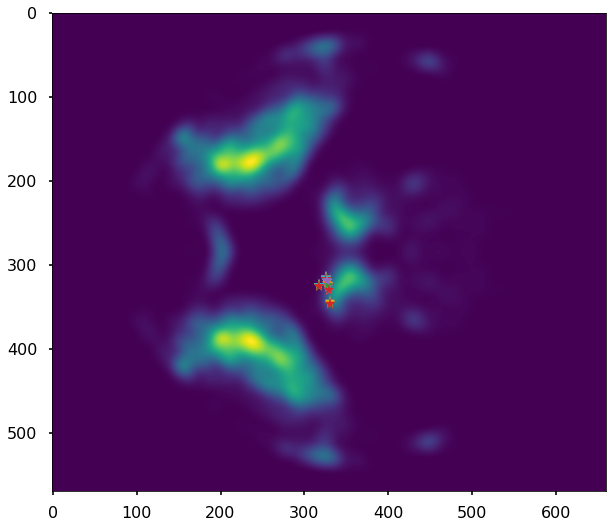

3960.0


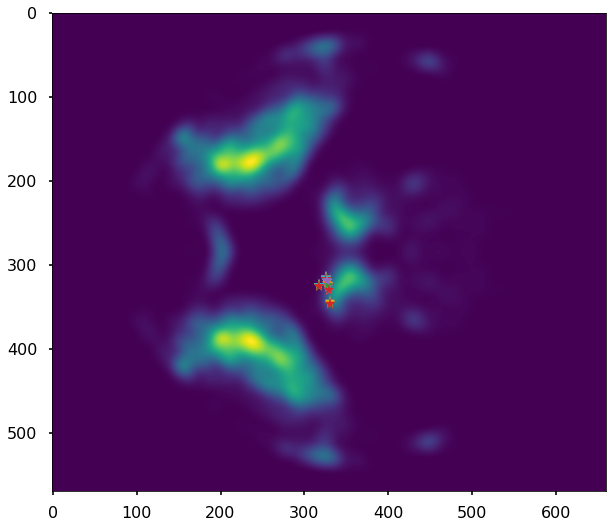

3740.0


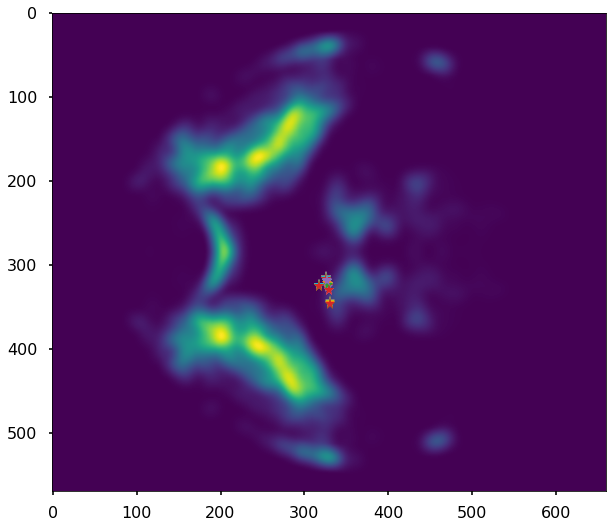

3700.0


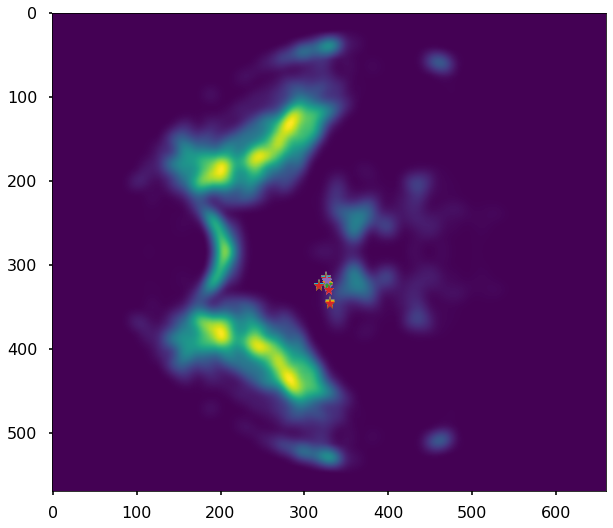

3340.0


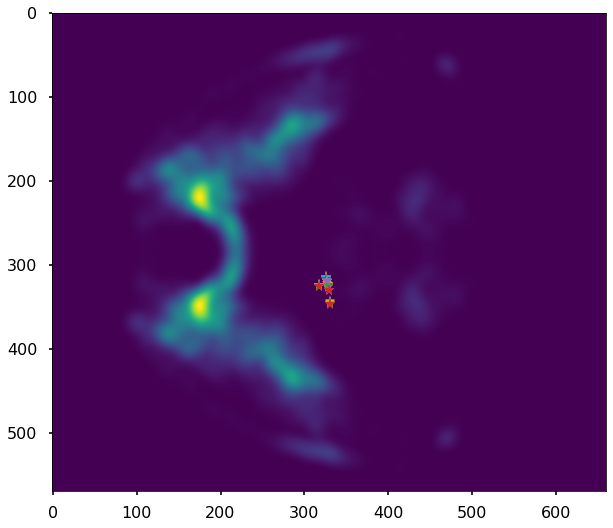

2640.0


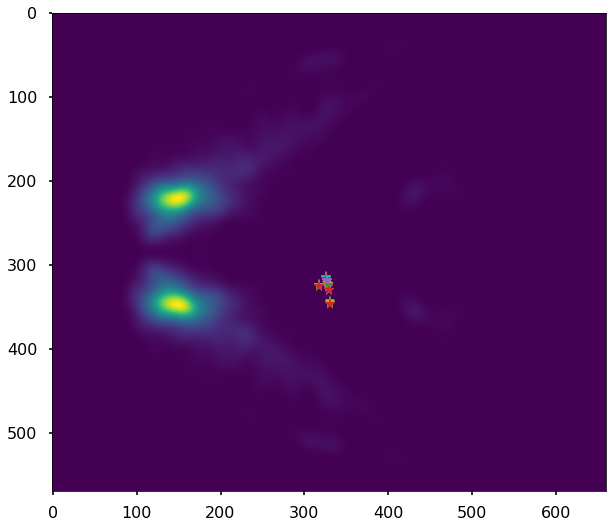

3960.0


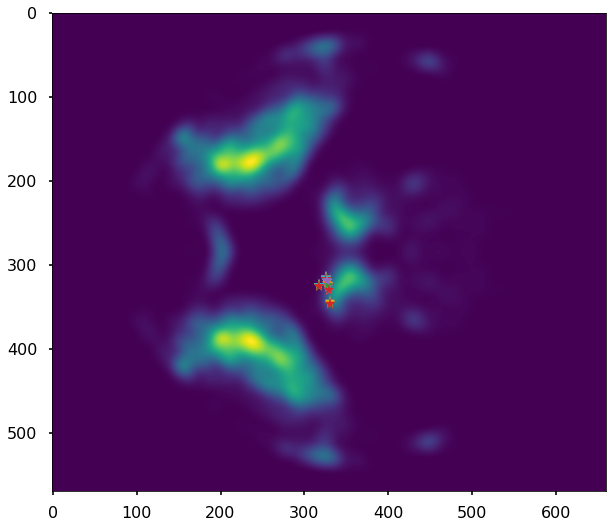

5600.0


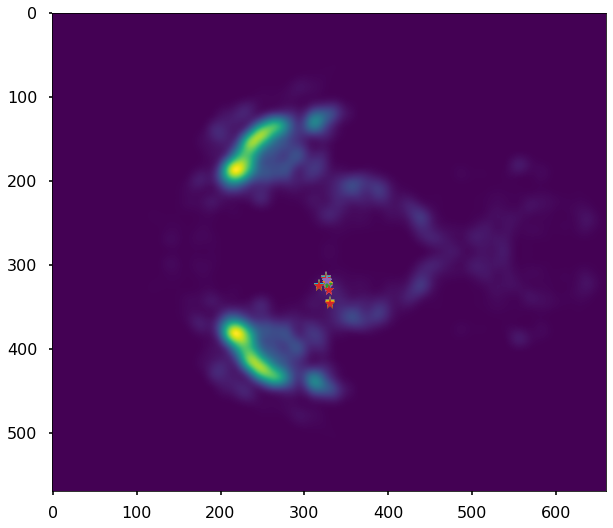

5600.0


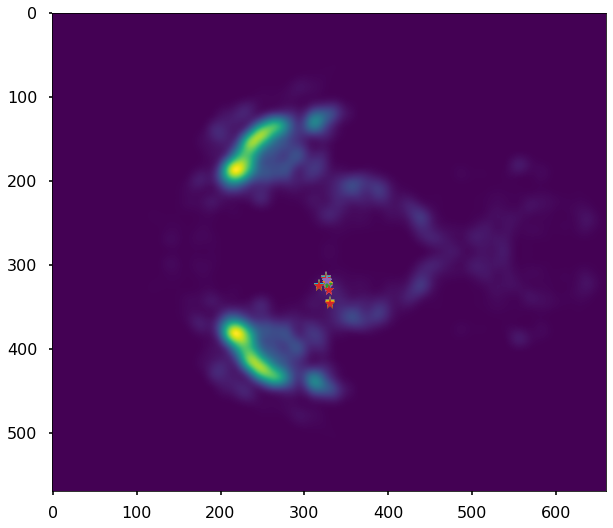

5580.0


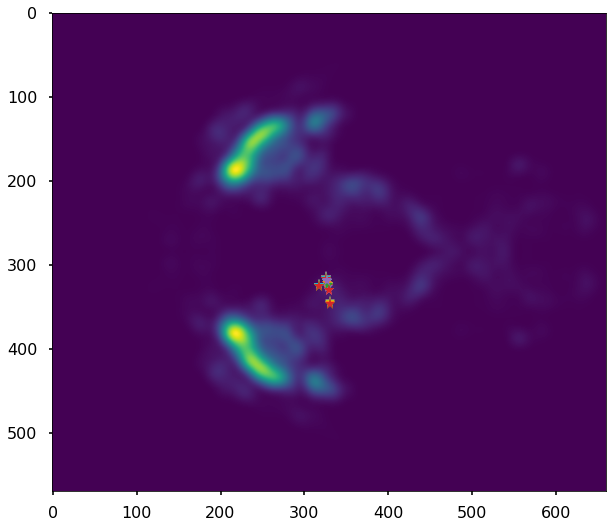

5540.0


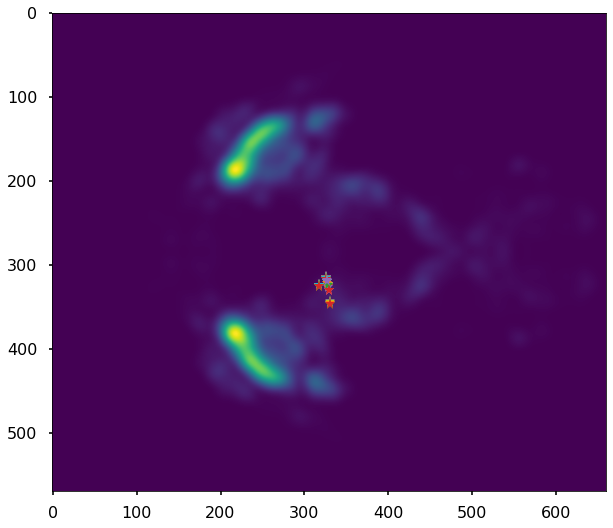

5380.0


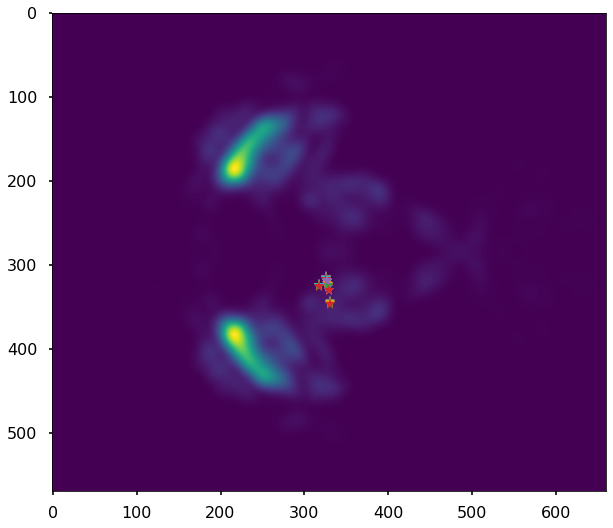

5240.0


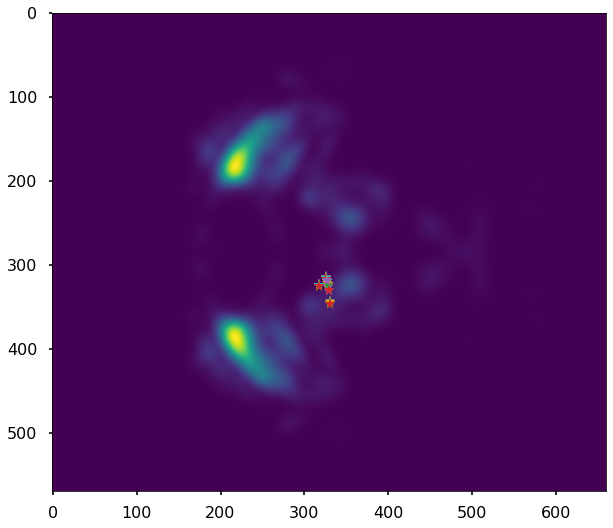

5200.0


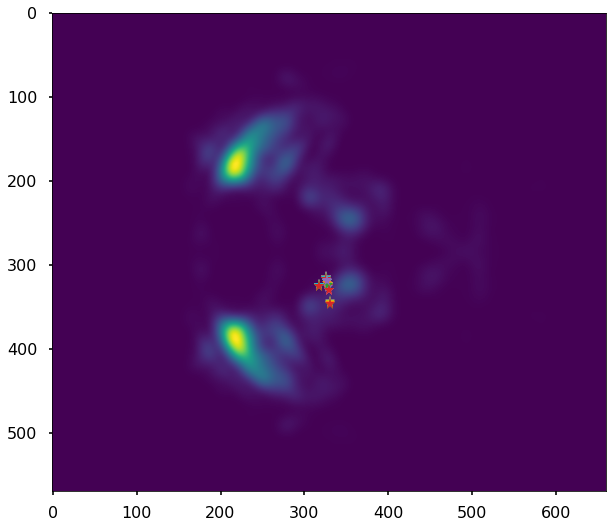

5200.0


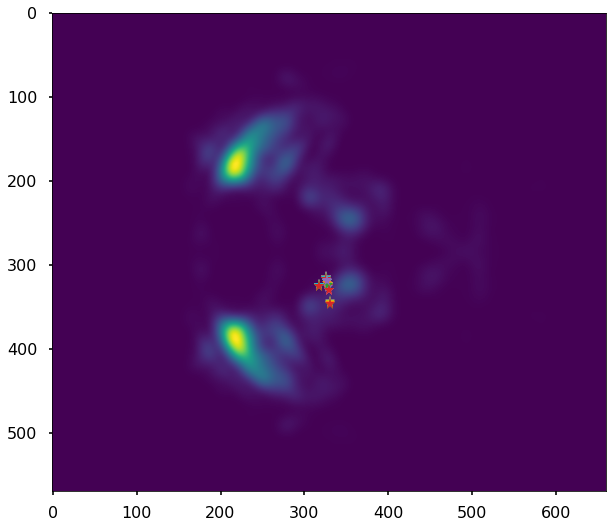

5180.0


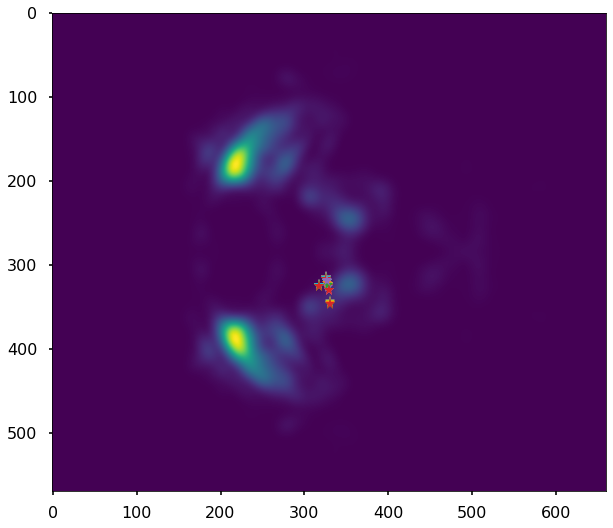

In [152]:
for j in y:
    plt.imshow(vox[int(j/20),:,:])
    for i in range(len(x)):
        plt.plot((z[i]/20),x[i]/20,marker='*')
    print(j)
    plt.show()

AttributeError: 'Series' object has no attribute 'x'

In [255]:
x_alm, y_alm, z_alm = [],[],[]

units_Data = unit_result.query(" Region == 'left ALM'")
for i in list(units_Data.electrodes.reset_index()['index'][:]):
    try:
        x_ccf, y_ccf, z_ccf = get_ccf(i)
        x_alm.append(x_ccf)
        y_alm.append(y_ccf)
        z_alm.append(z_ccf)

    except Exception as err:
        pass
ids=[]
for i in range(len(units_Data)):
    try:
        if(float(units_Data.electrodes[i].reset_index().y.values) > 0):
            ids.append(i)
    except Exception as err:
        pass

In [272]:
units_Data.loc[35].electrodes

location  \
id                                                       
209  {"brain_regions": "left ALM", "skull_reference...   

                                                 group         group_name  \
id                                                                          
209  17216703352 1-301 pynwb.ecephys.ElectrodeGroup...  17216703352 1-301   

     electrode  shank  shank_col  shank_row       x       y       z  imp  \
id                                                                         
209        210      1          2        105  7060.0  2720.0  2320.0 -1.0   

    filtering  rel_x   rel_y  rel_z  
id                                   
209             48.0  2080.0    NaN

In [129]:
y_alm[5],x_alm[5],z_alm[5]

(2720.0, 7060.0, 2320.0)

In [ ]:
for i in range(len(units_Data)):
    try:
        if(float(units_Data.electrodes[i].reset_index().y.values) >=231):
            print(i)
            break
    except Exception as err:
        pass

In [112]:
dv = ALM_mat['ALMsoma_dv']
ml = ALM_mat['ALMsoma_ml']
ap = ALM_mat['ALMsoma_ap']

In [118]:
vox_alm = []
for a2, b2, c2 in zip(dv, ml, ap):
    vox_alm.append((a2, b2, c2))
len(vox_alm)

212

In [147]:
dv[43]

array([2289.380367])

In [148]:
vox_alm[43]

(array([2289.380367]), array([6868.070743]), array([2502.64986469]))

In [9]:
%pip install units

  Created wheel for units: filename=units-0.7-py3-none-any.whl size=23919 sha256=7ebdb7b17bfe70ff27c45958ffe5d831d279575e3cb3dcf605663918907facb4
  Stored in directory: c:\users\smit3\appdata\local\pip\cache\wheels\7e\59\92\488fdbe7d6fe0e68c451ce8583efe6bb8ababc862de8cb2069
Successfully built units
Note: you may need to restart the kernel to use updated packages.


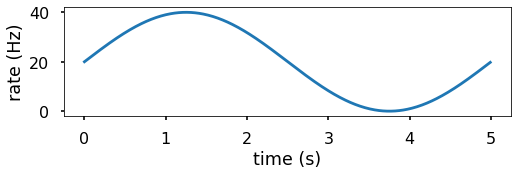

In [87]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import units as u
tmax = 5 
max_rate = 40
f_osc =  0.2
bin_size = 0.01
time = np.arange(0, tmax, bin_size)
rate = max_rate * (np.sin(2*np.pi*f_osc*time)+1)/2

plt.figure(figsize=(8, 2))
plt.plot(time, rate)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)');

In [88]:
list(rate1).index(rate1.max())

0

In [89]:
list(rate).index(rate.max())

125

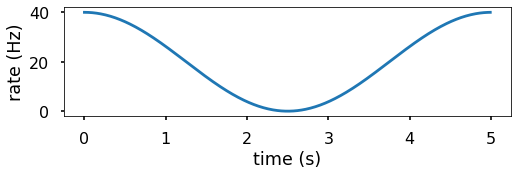

In [90]:
rate1 = max_rate * (np.cos(2*np.pi*f_osc*time)+1)/2

plt.figure(figsize=(8, 2))
plt.plot(time, rate1)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)');

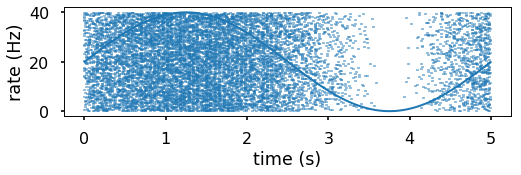

In [91]:
def inhomogeneous_poisson(rate, bin_size):
    n_bins = len(rate)
    spikes = np.random.rand(n_bins) < rate * bin_size
    spike_times = np.nonzero(spikes)[0] * bin_size
    return spike_times

def inhomogeneous_poisson_generator(n_trials, rate, bin_size):
    for i in range(n_trials):
        yield inhomogeneous_poisson(rate, bin_size)

def raster_plot_multi(spike_times):
    for i, spt in enumerate(spike_times):
        plt.vlines(spt, i, i+1)
    plt.yticks([])
    
    
n_trials = 100

plt.figure(figsize=(8,2))
plt.plot(time, rate, lw=2)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')
spike_times = list(inhomogeneous_poisson_generator(n_trials, rate, bin_size))
plt.twinx()
raster_plot_multi(spike_times)

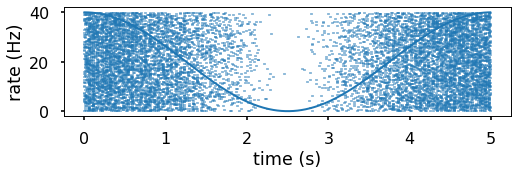

In [92]:
plt.figure(figsize=(8,2))
plt.plot(time, rate1, lw=2)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')
spike_times1 = list(inhomogeneous_poisson_generator(n_trials, rate1, bin_size))
plt.twinx()
raster_plot_multi(spike_times1)

In [93]:
spikes = []
spikes_shift = []
for i, spt in enumerate(spike_times):
#     print(i,spt)
    hist, edges = np.histogram(np.hstack(spt), bins=(np.arange(501)/100))
    spikes.append(hist)
    
for i, spt in enumerate(spike_times1):
#     print(i,spt)
    hist, edges = np.histogram(np.hstack(spt), bins=(np.arange(501)/100))
    spikes_shift.append(hist)

In [94]:
CCG_F= []
for j in range(len(spikes)):
    CCG = []
    for n in range(499):
        CCG.append(spikes[j][(499 - n):].dot(spikes_shift[j][:n+1]))
    CCG.append(spikes[j].dot(spikes_shift[j]))
    for n in range(498):
        CCG.append(spikes[j][:(499-n)].dot(spikes_shift[j][n+1:]))
    CCG_F.append(CCG)
CCG = np.sum(CCG_F,axis=0)
CCG.shape

(998,)

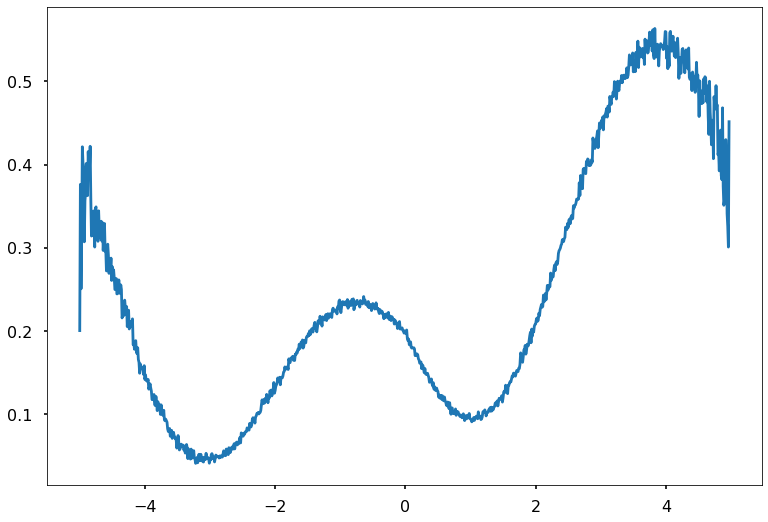

In [95]:
tr = np.arange(-(500-1),(500-1))
theta = 500-np.abs(tr)

plt.plot((np.arange(998)-500)/100,CCG/(theta*100*np.sqrt(np.mean(spikes)*np.mean(spikes_shift))))

In [275]:
units_Data = unit_result.query(" Region == 'left Thalamus'")
thal_spike = units_Data.loc[125]
units_Data = unit_result.query(" Region == 'left ALM'")
ALM_spike = units_Data.loc[35]

In [281]:
after = 4.3
before = -0.7

def Spike_time(temp_unit):
    All_trial_spike = []
    unit_spike_times = temp_unit["spike_times"]
    trial_spikes_l = []
    spike_data_l = []
    i = 0
    trial_spikes_l_agg = []
    for time in trials_Data_L['sample_start']:
        # Compute spike times relative to stimulus onset
        aligned_spikes = unit_spike_times - time
        # Keep only spike times in a given time window around the stimulus onset
        aligned_spikes = aligned_spikes[aligned_spikes < after ]
        aligned_spikes = aligned_spikes[before < aligned_spikes]
        trial_spikes_l.append(aligned_spikes)

        hist, edges = np.histogram(np.hstack(trial_spikes_l), bins=(np.arange(1001)/200) - 1)
        freq = (hist)
        trial_spikes_l_agg.append(freq)
    return trial_spikes_l_agg
    
spike_alm = Spike_time(ALM_spike)
spike_thal = Spike_time(thal_spike)

In [310]:
CCG_F= []
for j in range(len(spike_alm)):
    CCG = []
    for n in range(999):
        CCG.append(spike_alm[j][(999 - n):].dot(spike_thal[j][:n+1]))
    CCG.append(spike_alm[j].dot(spike_thal[j]))
    for n in range(998):
        CCG.append(spike_alm[j][:(999-n)].dot(spike_thal[j][n+1:]))
    CCG_F.append(CCG)
CCG = np.sum(CCG_F,axis=0)
CCG.shape

(1998,)

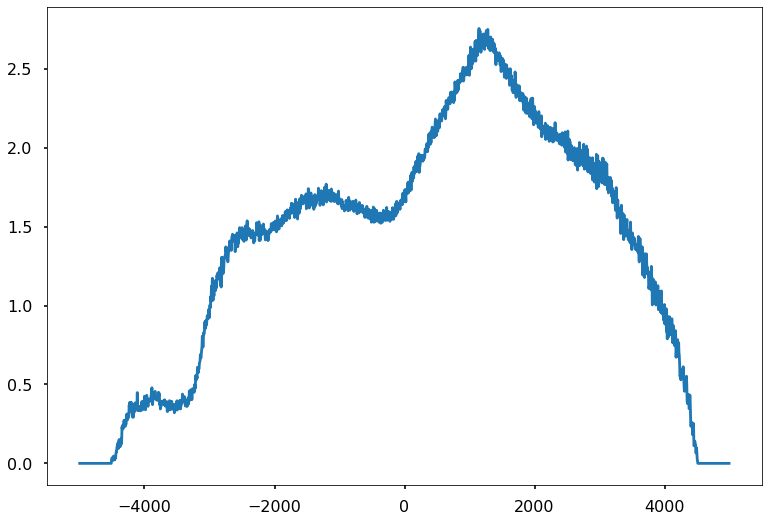

In [311]:
tr = np.arange(-(1000-1),(1000-1))
theta = 1000-np.abs(tr)
time = np.arange(-4995,4995,5)

plt.plot(time,CCG/(theta*len(spike_alm)*np.sqrt(np.mean(spike_alm)*np.mean(spike_thal))))

In [301]:
import random
temp_trial_spike_25 = np.zeros((10, 1, 101, 1000))  #(,,,)

for t in range(temp_trial_spike_25.shape[0]):
    for k in range(temp_trial_spike_25.shape[1]):
        for j in range(temp_trial_spike_25.shape[2]):
            for i in range(200):
                temp_sum = spike_thal[j][(i*5):(i*5)+5].sum()
                if(temp_sum != 0):
                    for m in range(temp_sum):
                        loc_trial, loc_spike = random.randint(0,100),random.randint((i*5),(i*5)+4)
                        temp_trial_spike_25[t][k][loc_trial][loc_spike] += 1

temp_trial_spike_alm_25 = np.zeros((10, 1, 101, 1000))

for t in range(temp_trial_spike_alm_25.shape[0]):
    for k in range(temp_trial_spike_alm_25.shape[1]):
        for j in range(temp_trial_spike_alm_25.shape[2]):
            for i in range(40):
                temp_sum = spike_alm[j][(i*25):(i*25)+25].sum()
                if(temp_sum != 0):
                    for m in range(temp_sum):
                        loc_trial, loc_spike = random.randint(0,100),random.randint((i*25),(i*25)+24)
                        temp_trial_spike_alm_25[t][k][loc_trial][loc_spike] += 1

In [302]:
temp_trial_spike_25 = temp_trial_spike_25.mean(axis=0)
temp_trial_spike_alm_25 = temp_trial_spike_alm_25.mean(axis=0)
temp_trial_spike_25.shape

(1, 101, 1000)

In [303]:
CCGs1_25 = []
for i in range(len(temp_trial_spike_25)):
    for k in range(1):
        CCG_F1= []
        for j in range(len(temp_trial_spike_alm_25[0])):
            CCG = []
            for n in range(999):
                CCG.append(temp_trial_spike_25[i][j][(999 - n):].dot(temp_trial_spike_alm_25[k][j][:n+1]))
            CCG.append(temp_trial_spike_25[i][j].dot(temp_trial_spike_alm_25[k][j]))
            for n in range(998):
                CCG.append(temp_trial_spike_25[i][j][:(999-n)].dot(temp_trial_spike_alm_25[k][j][n+1:]))
            CCG_F1.append(CCG)
        CCGs1_25.append(CCG_F1)

In [304]:
CCG1_25 = np.sum(CCGs1_25,axis=1)
CCG1_25.shape

(1, 1998)

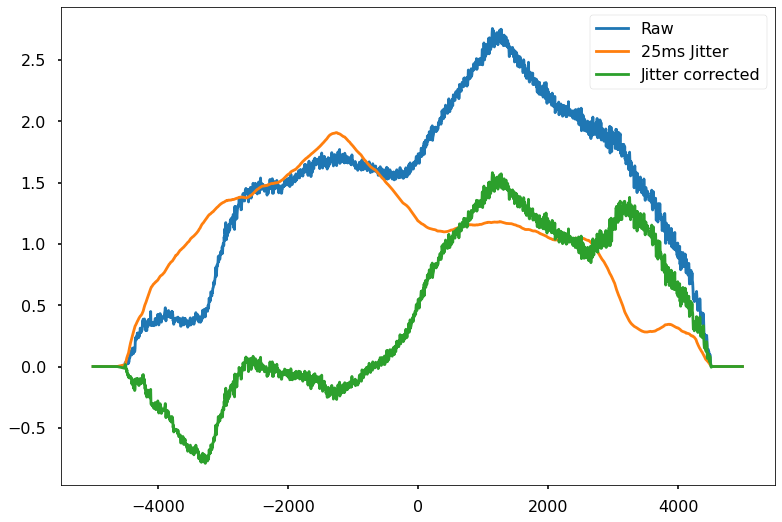

In [315]:
CCG_jitter_25 = CCG1_25[i] / (len(temp_trial_spike_25[0]) *theta* np.sqrt(np.mean(temp_trial_spike_alm_25[0])*np.mean(temp_trial_spike_25[i])))
CCG_raw = CCG/(theta*len(spike_alm)*np.sqrt(np.mean(spike_alm)*np.mean(spike_thal)))
plt.plot(time,CCG_raw)
plt.plot(time,CCG_jitter_25)
plt.plot(time,CCG_raw - CCG_jitter_25)
plt.legend(['Raw','25ms Jitter','Jitter corrected'])